# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
from scipy import sparse
import os
import networkx as nx

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
tfidf_reports = "../../../reports/tfidf/"
reports_comunidades = "../../../reports/analisis_comunidades/"
reports_jaccard = "../../../reports/jaccard_gene_similarity/"

In [4]:
graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
G = nx.read_gml(data_processed+"graph_data/gda_network.gml", destringizer=int)
nodos_gda = pd.DataFrame(dict(G.nodes(data=True))).T.reset_index().rename(columns={"index":"node_index"})
nodos_enfermedad = nodos_gda.loc[nodos_gda.node_type == "disease", "node_index"].sort_values().values

In [10]:
nodos_gda

,node_index,node_type,node_name,node_id,node_source
0,19599,disease,Hepatomegaly,C0019209,disgenet
1,0,gene_protein,A1BG,1,disgenet
2,20754,disease,Schizophrenia,C0036341,disgenet
3,9300,gene_protein,TRIM37,4591,disgenet
4,3967,gene_protein,AHR,196,disgenet
...,...,...,...,...,...
20851,29186,disease,"Patella aplasia, coxa vara, tarsal synostosis",C1868581,disgenet
20852,30660,disease,CHROMOSOME 17q23.1-q23.2 DUPLICATION SYNDROME,C3150880,disgenet
20853,34049,disease,HENNEKAM LYMPHANGIECTASIA-LYMPHEDEMA SYNDROME 3,C4748408,disgenet
20854,23348,disease,Late fontanel closure,C0277828,disgenet


In [5]:
nodos_enfermedad

array([18430, 18431, 18432, ..., 34192, 34194, 34195])

# Jaccard de genes compartidos

Ver para clusters asociados con cancer. Ver para casos no nulos (dirección inversa).

In [42]:
def jaccard(set1,set2):
    intersection = len(set1&set2)
    union = len(set1|set2)
    return round(intersection/union,2)

def overlap(set1,set2):
    intersection = len(set1&set2)
    min_set = min([len(set1),len(set2)])
    return intersection/min_set

In [40]:
conjuntos_enfermedad = {}

for enfermedad in nodos_enfermedad:
    vecinos = list(G.neighbors(enfermedad))
    conjuntos_enfermedad[enfermedad] = set(vecinos)

In [108]:
matrix_jaccard = np.zeros((len(nodos_enfermedad), len(nodos_enfermedad)))

In [109]:
for i in range(len(nodos_enfermedad)):
    for j in range(len(nodos_enfermedad)):
        nodo_i = nodos_enfermedad[i]
        nodo_j = nodos_enfermedad[j]
        conjunto_i = conjuntos_enfermedad[nodo_i]
        conjunto_j = conjuntos_enfermedad[nodo_j]
        coef = jaccard(conjunto_i, conjunto_j)
        matrix_jaccard[i,j] = coef

In [112]:
sparse_jaccard = sparse.csr_matrix(matrix_jaccard)
# sparse.save_npz(reports_jaccard+"jaccard_sparse_matrix.npz",sparse_jaccard)
df_jaccard_sparse = pd.DataFrame.sparse.from_spmatrix(sparse_jaccard, index=nodos_enfermedad, columns=nodos_enfermedad)

In [142]:
matrix_overlap = np.zeros((len(nodos_enfermedad), len(nodos_enfermedad)))

for i in range(len(nodos_enfermedad)):
    for j in range(len(nodos_enfermedad)):
        nodo_i = nodos_enfermedad[i]
        nodo_j = nodos_enfermedad[j]
        conjunto_i = conjuntos_enfermedad[nodo_i]
        conjunto_j = conjuntos_enfermedad[nodo_j]
        coef = overlap(conjunto_i, conjunto_j)
        matrix_overlap[i,j] = coef

In [145]:
sparse_overlap = sparse.csr_matrix(matrix_overlap)
df_overlap_sparse = pd.DataFrame.sparse.from_spmatrix(sparse_overlap, index=nodos_enfermedad, columns=nodos_enfermedad)
# sparse.save_npz(reports_jaccard+"overlap_sparse_matrix.npz",sparse_overlap)

# Similaridad jaccard vs comunidades

## Checkpoint

In [67]:
sparse_jaccard = sparse.load_npz(reports_jaccard+"jaccard_sparse_matrix_2.npz")
df_jaccard_sparse = pd.DataFrame.sparse.from_spmatrix(sparse_jaccard, index=nodos_enfermedad, columns=nodos_enfermedad)

sparse_overlap = sparse.load_npz(reports_jaccard+"overlap_sparse_matrix.npz")
df_overlap_sparse = pd.DataFrame.sparse.from_spmatrix(sparse_overlap, index=nodos_enfermedad, columns=nodos_enfermedad)

In [16]:
graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
disease_attributes = pd.read_csv(data_interim+"grafo_alternativo_disease_attributes.csv")

nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

tamaños_louvain = disease_attributes.comunidades_louvain.value_counts()
tamaños_infomap = disease_attributes.comunidades_infomap.value_counts()

infomap_clusters = pd.DataFrame(tamaños_infomap).reset_index().rename(columns={"index":"comunidad","comunidades_infomap":"tamaño"}).astype({"comunidad":"int"})
louvain_clusters = pd.DataFrame(tamaños_louvain).reset_index().rename(columns={"index":"comunidad","comunidades_louvain":"tamaño"}).astype({"comunidad":"int"})

In [68]:
df_overlap_sparse

,32009,20593,27883,28232,22377,31997,28747,31109,29582,32644,...,30590,26044,32192,32493,24923,33183,28944,18435,28127,31433
32009,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20593,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27883,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28232,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22377,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,...,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
28127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [69]:
no_nulos = (sparse_jaccard.nnz - 11167)/2
print(no_nulos)

710168.0


In [17]:
def mean_similarity_triu(similarity_matrix, cluster, algoritmo):
    nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].node_index.values
    nodos_disponibles = list(set(nodos_cluster)&set(nodos_enfermedad))
    cluster_matrix = similarity_matrix.loc[nodos_disponibles,nodos_disponibles].values
    indices = np.triu_indices_from(cluster_matrix,1)
    values = cluster_matrix[indices]
    return round(np.mean(values), 2)

Calculo mean sim jaccard

In [18]:
infomap_similarity = pd.Series({cluster:mean_similarity_triu(df_jaccard_sparse, cluster, "comunidades_infomap") for cluster in infomap_clusters.comunidad.values}, name="jaccard_mean_similarity")
louvain_similarity = pd.Series({cluster:mean_similarity_triu(df_jaccard_sparse, cluster, "comunidades_louvain") for cluster in louvain_clusters.comunidad.values}, name="jaccard_mean_similarity")

infomap_clusters = pd.merge(infomap_clusters,infomap_similarity, left_on="comunidad",right_index=True)
louvain_clusters = pd.merge(louvain_clusters,louvain_similarity, left_on="comunidad",right_index=True)

/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

Text(0.5, 1.0, 'Louvain')

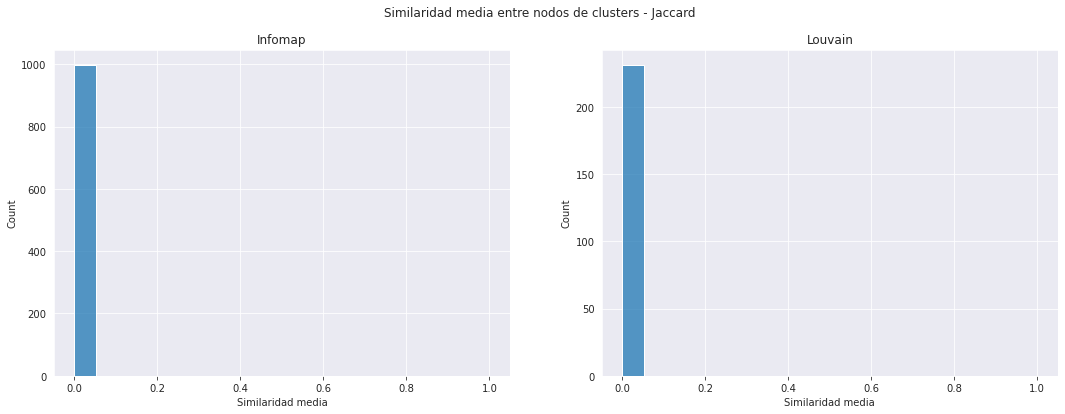

In [19]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f"Similaridad media entre nodos de clusters - Jaccard")

sns.histplot(data=infomap_clusters["jaccard_mean_similarity"], ax=ax[0], bins=np.linspace(0,1,20))
ax[0].set_xlabel("Similaridad media")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters["jaccard_mean_similarity"], ax=ax[1],bins=np.linspace(0,1,20))
ax[1].set_xlabel("Similaridad media")
ax[1].set_title("Louvain")

Calculo mean sim overlap

In [20]:
infomap_overlap = pd.Series({cluster:mean_similarity_triu(df_overlap_sparse, cluster, "comunidades_infomap") for cluster in infomap_clusters.comunidad.values}, name="mean_overlap_coef")
louvain_overlap = pd.Series({cluster:mean_similarity_triu(df_overlap_sparse, cluster, "comunidades_louvain") for cluster in louvain_clusters.comunidad.values}, name="mean_overlap_coef")

infomap_clusters = pd.merge(infomap_clusters,infomap_overlap, left_on="comunidad",right_index=True)
louvain_clusters = pd.merge(louvain_clusters,louvain_overlap, left_on="comunidad",right_index=True)

/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

Text(0.5, 1.0, 'Louvain')

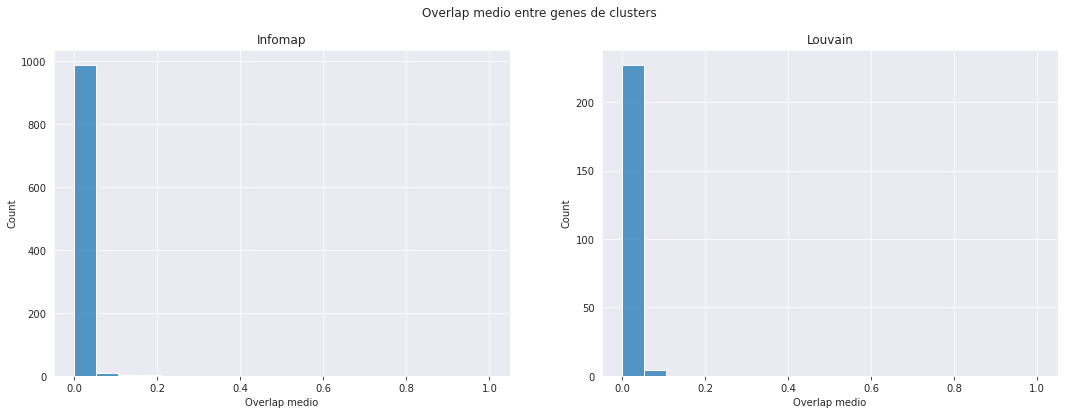

In [21]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f"Overlap medio entre genes de clusters")

sns.histplot(data=infomap_clusters["mean_overlap_coef"], ax=ax[0], bins=np.linspace(0,1,20))
ax[0].set_xlabel("Overlap medio")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters["mean_overlap_coef"], ax=ax[1],bins=np.linspace(0,1,20))
ax[1].set_xlabel("Overlap medio")
ax[1].set_title("Louvain")

In [24]:
# louvain_clusters.to_csv(reports_jaccard+"jaccard_overlap_louvain.csv",index=False)
# infomap_clusters.to_csv(reports_jaccard+"jaccard_overlap_infomap.csv",index=False)

# Veo clusters específicos

In [28]:
infomap_tfidf_data = pd.read_pickle("../../../reports/tfidf/infomap_analysis_checkpoint.pkl")
louvain_tfidf_data = pd.read_pickle("../../../reports/tfidf/louvain_analysis_checkpoint.pkl")

conectividad_infomap = pd.read_csv(reports_comunidades+"grado_gda_infomap.csv")
conectividad_louvain = pd.read_csv(reports_comunidades+"grado_gda_louvain.csv")

infomap_clusters = pd.read_csv(reports_jaccard+"jaccard_overlap_infomap.csv")
louvain_clusters = pd.read_csv(reports_jaccard+"jaccard_overlap_louvain.csv")

all_data_infomap = pd.merge(infomap_clusters, conectividad_infomap, left_on="comunidad", right_on="comunidad")
all_data_louvain = pd.merge(louvain_clusters, conectividad_louvain, left_on="comunidad", right_on="comunidad")

In [32]:
infomap_tfidf_data[infomap_tfidf_data.top_5_monograms.apply(lambda x: "depression" in x)]

,comunidad,tamaño,mean_similarity_mono,mean_similarity_bi,mean_similarity_tri,entropia_1,entropia_2,entropia_3,top_monogram,top_monogram_score,...,top_5_monograms,top_5_bigrams,top_5_trigrams,top_5_monograms_score,top_5_bigrams_score,top_5_trigrams_score,mean_similarity_mono_triu,mean_similarity_bi_triu,mean_similarity_tri_triu,pvalor
26,522,39,0.14,0.06,0.05,0.69,0.63,0.51,depression,0.36,...,"[depression, eat, sleep, anxiety, fear]","[traumatic event, binge eat, loss pleasure, me...","[thought death suicide, institute mental healt...","[0.36, 0.35, 0.26, 0.22, 0.21]","[0.32, 0.3, 0.22, 0.17, 0.14]","[0.31, 0.3, 0.3, 0.28, 0.25]",0.12,0.04,0.03,0.0
886,551,5,0.62,0.62,0.58,0.51,0.41,0.28,depression,0.40,...,"[depression, nearly, day, episode, mood]","[day nearly, diminish ability, ability think, ...","[day nearly daily, significant weight loss, on...","[0.4, 0.34, 0.28, 0.24, 0.2]","[0.31, 0.3, 0.3, 0.23, 0.23]","[0.41, 0.41, 0.31, 0.31, 0.31]",0.53,0.52,0.52,0.0


In [34]:
ejemplo = 522

In [235]:
graph_node_data[graph_node_data.comunidades_infomap == ejemplo].sort_values(by="degree_gda",ascending=False)

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
19010,19096,C0011581,Depressive disorder,disease,disgenet,522.0,0.0,289.0,0.0,1.0
20886,21060,C0041696,Unipolar Depression,disease,disgenet,522.0,0.0,259.0,0.0,1.0
19006,19092,C0011570,Mental Depression,disease,disgenet,522.0,0.0,254.0,0.0,1.0
24436,24838,C0525045,Mood Disorders,disease,disgenet,522.0,0.0,168.0,0.0,1.0
18539,18609,C0003469,Anxiety Disorders,disease,disgenet,522.0,0.0,44.0,0.0,1.0
23163,23485,C0282126,"Depression, Neurotic",disease,disgenet,522.0,0.0,41.0,0.0,1.0
19936,20064,C0025193,Melancholia,disease,disgenet,522.0,0.0,41.0,0.0,1.0
18632,18705,C0004936,Mental disorders,disease,disgenet,522.0,0.0,12.0,0.0,14.0
25377,25824,C0851578,Sleep Disorders,disease,disgenet,522.0,0.0,7.0,0.0,1.0
21954,22185,C0221074,"Depression, Postpartum",disease,disgenet,522.0,0.0,7.0,0.0,1.0


In [35]:
all_data_infomap[all_data_infomap.comunidad == ejemplo]

,comunidad,tamaño_x,jaccard_mean_similarity,mean_overlap_coef,tamaño_y,fraccion_gda,grado_gda_medio,max_grado_gda
26,522,39,0.0,0.01,39,0.56,52.27,289.0


In [47]:
nodo_1 = 19096
nodo_2 = 21060

set_1 = conjuntos_enfermedad[nodo_1]
set_2 = conjuntos_enfermedad[nodo_2]

name_1 = graph_node_data.loc[graph_node_data.node_index == nodo_1,"node_name"].values[0]
name_2 = graph_node_data.loc[graph_node_data.node_index == nodo_2,"node_name"].values[0]

In [44]:
round(overlap(set_1,set_2),2)

0.41

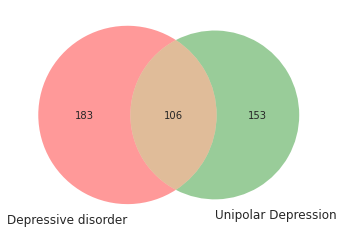

In [48]:
venn2([set_1,set_2],[name_1,name_2])

In [49]:
nodos_cluster = graph_node_data.loc[graph_node_data.comunidades_infomap == ejemplo, "node_index"].values
matrix_jaccard_cluster = np.zeros((len(nodos_cluster), len(nodos_cluster)))
nodos_cluster = list(set(nodos_cluster)&set(nodos_enfermedad))

for i in range(len(nodos_cluster)):
    for j in range(len(nodos_cluster)):
        nodo_i = nodos_cluster[i]
        nodo_j = nodos_cluster[j]
        conjunto_i = conjuntos_enfermedad[nodo_i]
        conjunto_j = conjuntos_enfermedad[nodo_j]
        coef = jaccard(conjunto_i, conjunto_j)
        matrix_jaccard_cluster[i,j] = coef

In [50]:
nodos_cluster = graph_node_data.loc[graph_node_data.comunidades_infomap == ejemplo, "node_index"].values
matrix_overlap_cluster = np.zeros((len(nodos_cluster), len(nodos_cluster)))
nodos_cluster = list(set(nodos_cluster)&set(nodos_enfermedad))

for i in range(len(nodos_cluster)):
    for j in range(len(nodos_cluster)):
        nodo_i = nodos_cluster[i]
        nodo_j = nodos_cluster[j]
        conjunto_i = conjuntos_enfermedad[nodo_i]
        conjunto_j = conjuntos_enfermedad[nodo_j]
        coef = overlap(conjunto_i, conjunto_j)
        matrix_overlap_cluster[i,j] = coef

In [51]:
matrix_overlap_cluster

array([[1.        , 0.25      , 0.53571429, ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 1.        , 0.41666667, ..., 0.        , 0.        ,
        0.        ],
       [0.53571429, 0.41666667, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [52]:
indices = np.triu_indices_from(matrix_jaccard_cluster,1)
values = matrix_jaccard_cluster[indices]

In [205]:
indices = np.triu_indices_from(matrix_overlap_cluster,1)
values = matrix_overlap_cluster[indices]

In [59]:
pd.DataFrame(matrix_jaccard_cluster, index=nodos_cluster, columns=nodos_cluster)

ValueError: Shape of passed values is (39, 39), indices imply (22, 22)

In [54]:
df_overlap_sparse.loc[nodos_cluster,nodos_cluster]

,24838,18705,19092,19095,19096,18593,23718,22185,18608,18481,...,20401,23485,19773,21060,21963,20064,25824,25961,19185,19191
24838,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.157895,0.0,0.0,0.0,0.000000,0.000000,0.0,0.037037
18705,0.000000,1.000000,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.083333,0.0,0.0,0.0,0.000000,0.083333,0.0,0.083333
19092,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
19095,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
19096,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
18593,0.000000,0.100000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.200000,0.0,0.0,0.0,0.000000,0.200000,0.0,0.200000
23718,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.500000,0.0,0.000000
22185,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
18608,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
18481,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000


In [84]:
sparse_jaccard_test = sparse.csr_matrix(matrix_jaccard_cluster)
df_jaccard_sparse_test = pd.DataFrame.sparse.from_spmatrix(sparse_jaccard_test, index=nodos_cluster, columns=nodos_cluster)

In [157]:
mean_similarity_triu(df_overlap_sparse,ejemplo,"comunidades_infomap")

0.6

In [71]:
all_data_infomap[all_data_infomap.comunidad == ejemplo]

,comunidad,tamaño_x,jaccard_mean_similarity,mean_overlap_coef,tamaño_y,fraccion_gda,grado_gda_medio,max_grado_gda,rangos_fraccion
26,522,39,0.0,0.01,39,0.56,52.27,289.0,2


In [55]:
df_jaccard_sparse.loc[nodos_cluster,nodos_cluster]

,24838,18705,19092,19095,19096,18593,23718,22185,18608,18481,...,20401,23485,19773,21060,21963,20064,25824,25961,19185,19191
24838,1.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.07,0.0,0.0,0.0,0.00,0.00,0.0,0.02
18705,0.00,1.00,0.0,0.0,0.0,0.05,0.00,0.0,0.0,0.0,...,0.0,0.0,0.03,0.0,0.0,0.0,0.00,0.02,0.0,0.03
19092,0.00,0.00,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00
19095,0.00,0.00,0.0,1.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00
19096,0.00,0.00,0.0,0.0,1.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00
18593,0.00,0.05,0.0,0.0,0.0,1.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.07,0.0,0.0,0.0,0.00,0.04,0.0,0.05
23718,0.00,0.00,0.0,0.0,0.0,0.00,1.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.02,0.0,0.00
22185,0.00,0.00,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00
18608,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,1.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00
18481,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,1.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00


# Visualizaciones

In [56]:
all_data_infomap = pd.merge(infomap_clusters, conectividad_infomap, left_on="comunidad", right_on="comunidad")

def facet_range(x):
    if x <= 0.3:
        return 1
    elif x <= 0.6:
        return 2
    else:
        return 3

all_data_infomap["rangos_fraccion"] =  all_data_infomap.fraccion_gda.apply(lambda x: facet_range(x))

In [57]:
fig = px.histogram(all_data_infomap, x="jaccard_mean_similarity", facet_col="rangos_fraccion")
fig.show()

In [58]:
all_data_infomap

,comunidad,tamaño_x,jaccard_mean_similarity,mean_overlap_coef,tamaño_y,fraccion_gda,grado_gda_medio,max_grado_gda,rangos_fraccion
0,3,198,0.0,0.00,198,0.86,2.79,109.0,3
1,354,82,0.0,0.00,82,0.79,1.74,12.0,3
2,188,74,0.0,0.00,74,0.99,1.75,24.0,3
3,416,74,0.0,0.01,74,0.93,2.54,104.0,3
4,436,71,0.0,0.00,71,0.75,3.26,37.0,3
...,...,...,...,...,...,...,...,...,...
1136,968,2,0.0,0.00,2,1.00,5.00,6.0,3
1137,1060,2,0.0,0.00,2,1.00,4.00,4.0,3
1138,1010,2,0.0,0.00,2,1.00,4.00,4.0,3
1139,1121,2,NaN,NaN,2,0.50,2.00,2.0,2


Definir una función que, dado un cluster, me muestre el df con los nodos, los puntajes de overlap y jaccard, un diagrama de venn y las estadísticas de tfidf con los términos. ( O juntar todo esto en una celda para cuando lo quiera mostrar)